In [310]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [311]:
# 1. Load and preprocess Titanic data
# ======================================================================

df = pd.read_csv("titanic (1).csv")
df


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [312]:

# Target and drop ID / high-cardinality text columns
target_col = "Survived"
drop_cols = ["PassengerId", "Name", "Ticket", "Cabin"]

for c in drop_cols:
    if c in df.columns:
        df = df.drop(columns=c)

# Simple imputation for numeric and categorical
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != target_col]
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

for c in num_cols:
    df[c] = df[c].fillna(df[c].median())
for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode()[0])

# Encode categorical with simple label encoding
for c in cat_cols:
    df[c] = df[c].astype("category").cat.codes
    

In [313]:
# Final feature matrix and target
X = df.drop(columns=[target_col]).values.astype(float)
y = df[target_col].values.astype(int)
df


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2
...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,2
887,1,1,0,19.0,0,0,30.0000,2
888,0,3,0,28.0,1,2,23.4500,2
889,1,1,1,26.0,0,0,30.0000,0


In [314]:
# Train-test split (80:20)
def train_test_split(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]
    n_test = int(len(X) * test_size)
    X_train, X_test = X[:-n_test], X[-n_test:]
    y_train, y_test = y[:-n_test], y[-n_test:]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [315]:
# Standardization (fit on train only)
def standardize_fit(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    sigma[sigma == 0] = 1.0
    return mu, sigma

def standardize_transform(X, mu, sigma):
    return (X - mu) / sigma

mu, sigma = standardize_fit(X_train)
X_train_std = standardize_transform(X_train, mu, sigma)
X_test_std = standardize_transform(X_test, mu, sigma)

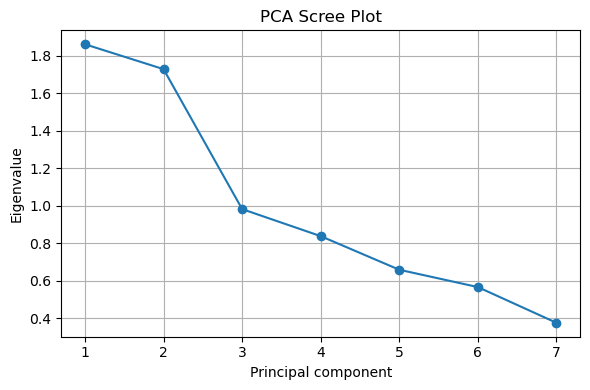

In [316]:
# 2. PCA from scratch
# ======================================================================

def pca_fit(X, n_components=None):
    # X is already standardized
    cov = np.cov(X, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)
    # Sort descending
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    if n_components is not None:
        eigvals = eigvals[:n_components]
        eigvecs = eigvecs[:, :n_components]
    return eigvals, eigvecs

def pca_transform(X, eigvecs):
    return X @ eigvecs

# Fit PCA on training data
eigvals, eigvecs = pca_fit(X_train_std)

# Scree plot
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(eigvals)+1), eigvals, marker='o')
plt.xlabel("Principal component")
plt.ylabel("Eigenvalue")
plt.title("PCA Scree Plot")
plt.grid(True)
plt.tight_layout()
plt.show()

In [317]:
# Choose number of components (e.g., keep 95% variance)
explained = eigvals / eigvals.sum()
cum_explained = np.cumsum(explained)
n_components = np.searchsorted(cum_explained, 0.95) + 1

X_train_pca = pca_transform(X_train_std, eigvecs[:, :n_components])
X_test_pca = pca_transform(X_test_std, eigvecs[:, :n_components])


In [318]:
# 3. SVM from scratch (linear, hinge loss, SGD)
# ======================================================================

class LinearSVM:
    def __init__(self, C=1.0, lr=0.001, n_epochs=1000, batch_size=32, random_state=42):
        self.C = C
        self.lr = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self.W = None
        self.b = None
        self.loss_history = []

    def _init_params(self, n_features):
        rng = np.random.RandomState(self.random_state)
        self.W = rng.randn(n_features)
        self.b = 0.0

    def decision_function(self, X):
        return X @ self.W + self.b

    def predict(self, X):
        scores = self.decision_function(X)
        return (scores >= 0).astype(int)

    def fit(self, X, y):
        # y in {0,1} -> convert to {-1, +1}
        y_ = np.where(y == 1, 1, -1)
        n_samples, n_features = X.shape
        self._init_params(n_features)

        rng = np.random.RandomState(self.random_state)

        for epoch in range(self.n_epochs):
            # mini-batch SGD
            idx = np.arange(n_samples)
            rng.shuffle(idx)
            X_shuf = X[idx]
            y_shuf = y_[idx]

            epoch_loss = 0.0
            for start in range(0, n_samples, self.batch_size):
                end = start + self.batch_size
                X_batch = X_shuf[start:end]
                y_batch = y_shuf[start:end]

                if len(X_batch) == 0:
                    continue

                margins = y_batch * (X_batch @ self.W + self.b)
                # Hinge loss
                loss = 0.5 * np.dot(self.W, self.W) + self.C * np.mean(np.maximum(0, 1 - margins))
                epoch_loss += loss * len(X_batch)

                # Gradient
                mis_idx = margins < 1
                if np.any(mis_idx):
                    X_mis = X_batch[mis_idx]
                    y_mis = y_batch[mis_idx].reshape(-1, 1)
                    grad_W = self.W - self.C * (X_mis * y_mis).mean(axis=0)
                    grad_b = -self.C * y_mis.mean()
                else:
                    grad_W = self.W
                    grad_b = 0.0

                self.W -= self.lr * grad_W
                self.b -= self.lr * grad_b

            epoch_loss /= n_samples
            self.loss_history.append(epoch_loss)

    def score(self, X, y):
        y_pred = self.predict(X)
        return (y_pred == y).mean()

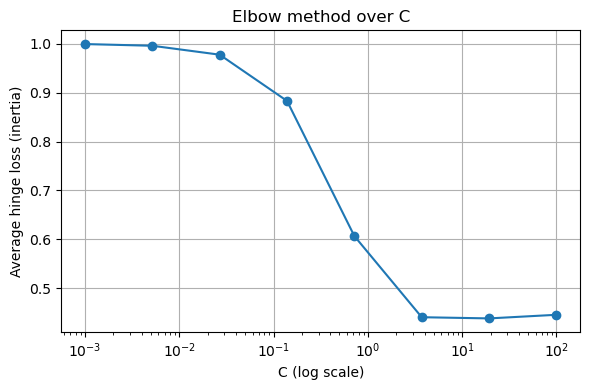

Best C (elbow-style): 19.306977288832496


In [319]:
# 4. Elbow method-style search over C (using "inertia" as hinge loss)
# ======================================================================

def compute_hinge_inertia(model, X, y):
    y_ = np.where(y == 1, 1, -1)
    margins = y_ * model.decision_function(X)
    hinge = np.maximum(0, 1 - margins)
    return hinge.mean()

C_values = np.logspace(-3, 2, 8)
inertias = []

for C in C_values:
    svm_tmp = LinearSVM(C=C, lr=0.001, n_epochs=300, batch_size=32, random_state=42)
    svm_tmp.fit(X_train_pca, y_train)
    inertia = compute_hinge_inertia(svm_tmp, X_train_pca, y_train)
    inertias.append(inertia)

plt.figure(figsize=(6,4))
plt.plot(C_values, inertias, marker='o')
plt.xscale('log')
plt.xlabel("C (log scale)")
plt.ylabel("Average hinge loss (inertia)")
plt.title("Elbow method over C")
plt.grid(True)
plt.tight_layout()
plt.show()

best_idx = np.argmin(inertias)
best_C = C_values[best_idx]
print("Best C (elbow-style):", best_C)

In [320]:
# 5. Dunn index and silhouette (treat SVM outputs as 2 clusters)
# ======================================================================

def pairwise_distances(X):
    # Euclidean distance matrix
    sum_X = np.sum(X**2, axis=1)
    dists = np.sqrt(np.maximum(sum_X[:,None] + sum_X[None,:] - 2 * X @ X.T, 0))
    return dists

def dunn_index(X, labels):
    # labels are {0,1}
    dists = pairwise_distances(X)
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return 0.0

    # inter-cluster distances (min)
    inter = np.inf
    for i in unique_labels:
        for j in unique_labels:
            if i >= j:
                continue
            idx_i = np.where(labels == i)[0]
            idx_j = np.where(labels == j)[0]
            if len(idx_i) == 0 or len(idx_j) == 0:
                continue
            inter_ij = dists[np.ix_(idx_i, idx_j)].min()
            inter = min(inter, inter_ij)

    # intra-cluster diameters (max)
    intra = 0.0
    for k in unique_labels:
        idx_k = np.where(labels == k)[0]
        if len(idx_k) <= 1:
            continue
        intra_k = dists[np.ix_(idx_k, idx_k)].max()
        intra = max(intra, intra_k)

    if intra == 0:
        return 0.0
    return inter / intra

def silhouette_score_manual(X, labels):
    dists = pairwise_distances(X)
    n = len(X)
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return 0.0
    sil_samples = []
    for i in range(n):
        same_cluster = labels == labels[i]
        other_clusters = [c for c in unique_labels if c != labels[i]]

        # a(i)
        idx_same = np.where(same_cluster)[0]
        if len(idx_same) > 1:
            a_i = dists[i, idx_same[idx_same != i]].mean()
        else:
            a_i = 0.0

        # b(i)
        b_i = np.inf
        for c in other_clusters:
            idx_c = np.where(labels == c)[0]
            if len(idx_c) == 0:
                continue
            b_i = min(b_i, dists[i, idx_c].mean())

        s_i = 0.0
        if max(a_i, b_i) > 0:
            s_i = (b_i - a_i) / max(a_i, b_i)
        sil_samples.append(s_i)
    return np.mean(sil_samples)

In [321]:
# 6. Train final SVM with best C on PCA features
# ======================================================================

svm = LinearSVM(C=best_C, lr=0.001, n_epochs=1000, batch_size=32, random_state=42)
svm.fit(X_train_pca, y_train)

train_acc = svm.score(X_train_pca, y_train)
test_acc = svm.score(X_test_pca, y_test)
print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)

y_train_pred = svm.predict(X_train_pca)
y_test_pred = svm.predict(X_test_pca)

# Dunn index and silhouette on train
dunn = dunn_index(X_train_pca, y_train_pred)
sil = silhouette_score_manual(X_train_pca, y_train_pred)
print("Dunn index (train):", dunn)
print("Silhouette score (train):", sil)


Train accuracy: 0.7840112201963534
Test accuracy: 0.8089887640449438
Dunn index (train): 0.17106515097899297
Silhouette score (train): 0.25519351786819006


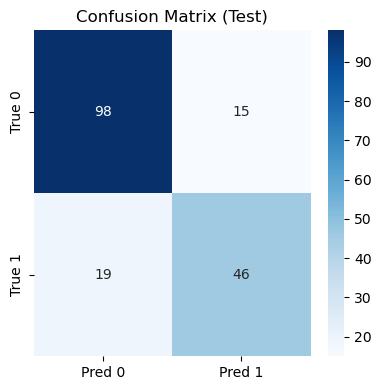

In [322]:
# 7. Confusion matrix, ROC, AUC, learning curve, hyperparameter heatmap
# ======================================================================

def confusion_matrix_manual(y_true, y_pred):
    # binary 0/1
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp],
                     [fn, tp]])

cm = confusion_matrix_manual(y_test, y_test_pred)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

Test AUC: 0.8582709326072159


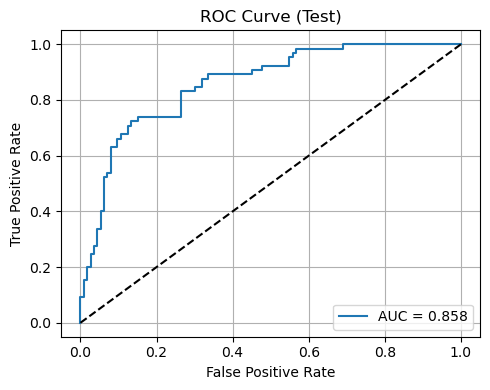

In [323]:
# ROC and AUC
def roc_curve_manual(y_true, scores):
    # y_true in {0,1}
    thresholds = np.unique(scores)
    thresholds = np.concatenate(([scores.max() + 1], thresholds[::-1], [scores.min() - 1]))
    tprs = []
    fprs = []
    for thr in thresholds:
        y_pred = (scores >= thr).astype(int)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fn = np.sum((y_true == 1) & (y_pred == 0))

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        tprs.append(tpr)
        fprs.append(fpr)
    return np.array(fprs), np.array(tprs)

def auc_manual(fprs, tprs):
    # Sort by FPR
    idx = np.argsort(fprs)
    fprs = fprs[idx]
    tprs = tprs[idx]
    # Trapezoidal rule
    area = 0.0
    for i in range(1, len(fprs)):
        area += (fprs[i] - fprs[i-1]) * (tprs[i] + tprs[i-1]) / 2.0
    return area

train_scores = svm.decision_function(X_train_pca)
test_scores = svm.decision_function(X_test_pca)

fpr_test, tpr_test = roc_curve_manual(y_test, test_scores)
auc_test = auc_manual(fpr_test, tpr_test)
print("Test AUC:", auc_test)

plt.figure(figsize=(5,4))
plt.plot(fpr_test, tpr_test, label=f"AUC = {auc_test:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

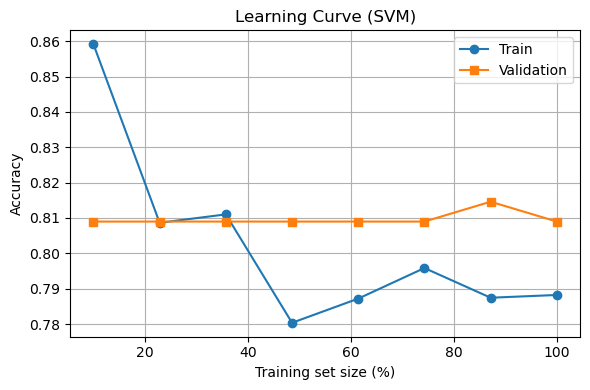

In [324]:
# Learning curve: vary number of training samples
train_sizes = np.linspace(0.1, 1.0, 8)
train_scores_lc = []
val_scores_lc = []

for frac in train_sizes:
    n_sub = int(len(X_train_pca) * frac)
    X_sub = X_train_pca[:n_sub]
    y_sub = y_train[:n_sub]

    svm_lc = LinearSVM(C=best_C, lr=0.001, n_epochs=800, batch_size=32, random_state=42)
    svm_lc.fit(X_sub, y_sub)

    train_scores_lc.append(svm_lc.score(X_sub, y_sub))
    val_scores_lc.append(svm_lc.score(X_test_pca, y_test))

plt.figure(figsize=(6,4))
plt.plot(train_sizes * 100, train_scores_lc, marker='o', label="Train")
plt.plot(train_sizes * 100, val_scores_lc, marker='s', label="Validation")
plt.xlabel("Training set size (%)")
plt.ylabel("Accuracy")
plt.title("Learning Curve (SVM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Hyperparameter heatmap over C and learning rate
C_grid = np.logspace(-3, 2, 6)
lr_grid = np.logspace(-4, -1, 4)
heatmap_scores = np.zeros((len(lr_grid), len(C_grid)))

for i, lr in enumerate(lr_grid):
    for j, C_val in enumerate(C_grid):
        svm_h = LinearSVM(C=C_val, lr=lr, n_epochs=500, batch_size=32, random_state=42)
        svm_h.fit(X_train_pca, y_train)
        heatmap_scores[i, j] = svm_h.score(X_test_pca, y_test)

plt.figure(figsize=(7,4))
sns.heatmap(heatmap_scores, annot=True, fmt=".2f",
            xticklabels=[f"{c:.1e}" for c in C_grid],
            yticklabels=[f"{lr:.1e}" for lr in lr_grid],
            cmap="viridis")
plt.xlabel("C")
plt.ylabel("Learning rate")
plt.title("Hyperparameter Heatmap (Accuracy on Test)")
plt.tight_layout()
plt.show()

In [ ]:
# 8. Decision boundary, support vectors, margin visualization
#    (use first 2 PCA components for 2D visualization)
# ======================================================================

X_train_2d = X_train_pca[:, :2]
X_test_2d = X_test_pca[:, :2]

svm_2d = LinearSVM(C=best_C, lr=0.001, n_epochs=1000, batch_size=32, random_state=42)
svm_2d.fit(X_train_2d, y_train)

In [ ]:
# Compute support vectors approximately: points with margin close to 1
y_train_pm = np.where(y_train == 1, 1, -1)
margins = y_train_pm * svm_2d.decision_function(X_train_2d)
support_mask = np.abs(1 - margins) < 0.05
support_vectors = X_train_2d[support_mask]

w = svm_2d.W
b = svm_2d.b

Train clusters (label -> count):
  Cluster 0: 529 samples
  Cluster 1: 184 samples

Test clusters (label -> count):
  Cluster 0: 138 samples
  Cluster 1: 40 samples

Total number of clusters in train predictions: 2
Total number of clusters in test predictions: 2


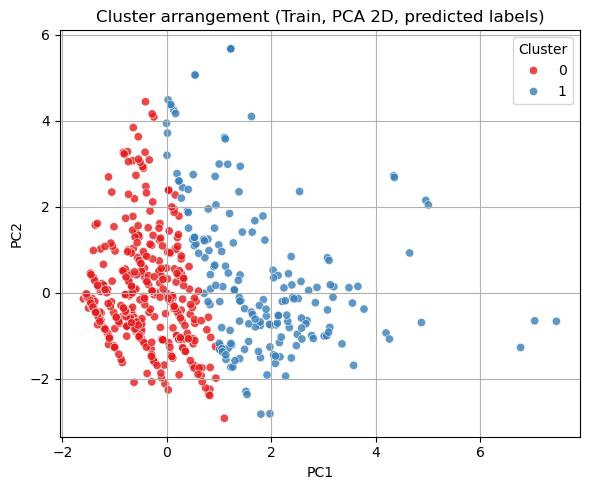

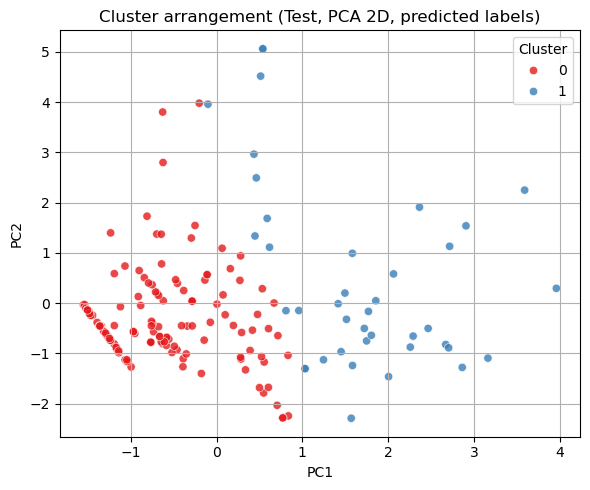

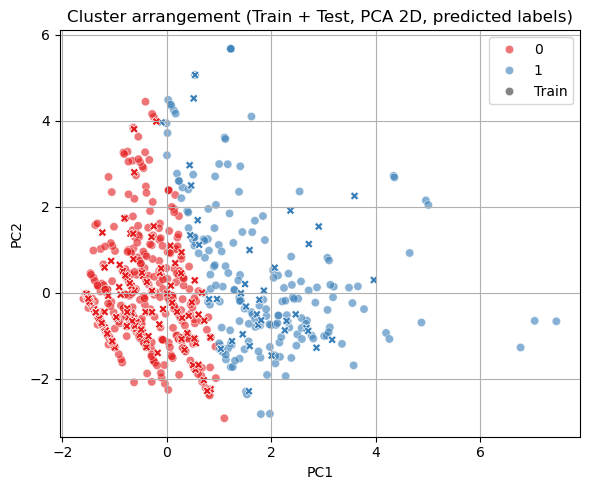

In [ ]:
# 10. Cluster count and arrangement visualization
#     using SVM predicted labels as "clusters"
# ======================================================================

# Use the 2D PCA train + test projections and SVM-2D model already defined:
# X_train_2d, X_test_2d, y_train_pred_2d, y_test_pred_2d, svm_2d

# If you don't have separate preds yet:
y_train_pred_2d = svm_2d.predict(X_train_2d)
y_test_pred_2d = svm_2d.predict(X_test_2d)

# 1) How many clusters (unique labels) are formed?
unique_clusters_train, counts_train = np.unique(y_train_pred_2d, return_counts=True)
unique_clusters_test, counts_test = np.unique(y_test_pred_2d, return_counts=True)

print("Train clusters (label -> count):")
for lab, cnt in zip(unique_clusters_train, counts_train):
    print(f"  Cluster {lab}: {cnt} samples")

print("\nTest clusters (label -> count):")
for lab, cnt in zip(unique_clusters_test, counts_test):
    print(f"  Cluster {lab}: {cnt} samples")

print("\nTotal number of clusters in train predictions:", len(unique_clusters_train))
print("Total number of clusters in test predictions:", len(unique_clusters_test))

# 2) Visualize how clusters are arranged in 2D PCA space (train)
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=X_train_2d[:,0],
    y=X_train_2d[:,1],
    hue=y_train_pred_2d,
    palette="Set1",
    alpha=0.8
)
plt.title("Cluster arrangement (Train, PCA 2D, predicted labels)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Visualize how clusters are arranged in 2D PCA space (test)
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=X_test_2d[:,0],
    y=X_test_2d[:,1],
    hue=y_test_pred_2d,
    palette="Set1",
    alpha=0.8
)
plt.title("Cluster arrangement (Test, PCA 2D, predicted labels)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) Combined train+test cluster arrangement
X_all_2d = np.vstack([X_train_2d, X_test_2d])
clusters_all = np.concatenate([y_train_pred_2d, y_test_pred_2d])
split_index = len(X_train_2d)

plt.figure(figsize=(6,5))
sns.scatterplot(
    x=X_all_2d[:split_index,0],
    y=X_all_2d[:split_index,1],
    hue=clusters_all[:split_index],
    palette="Set1",
    alpha=0.6,
    style=["Train"]*split_index  # style argument via list is okay but optional
)
sns.scatterplot(
    x=X_all_2d[split_index:,0],
    y=X_all_2d[split_index:,1],
    hue=clusters_all[split_index:],
    palette="Set1",
    alpha=1.0,
    marker="X",
    legend=False
)
plt.title("Cluster arrangement (Train + Test, PCA 2D, predicted labels)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

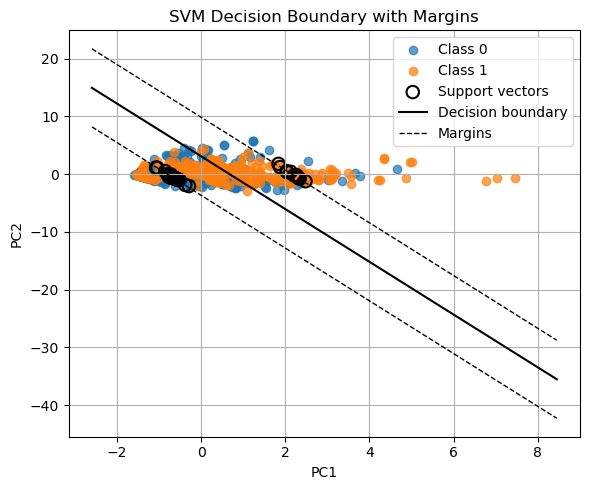

In [ ]:
# Decision boundary and margins: w1*x + w2*y + b = 0
def plot_decision_boundary_svm_2d(model, X, y, support_vectors):
    plt.figure(figsize=(6,5))
    # Scatter plot of data
    plt.scatter(X[y==0,0], X[y==0,1], c="tab:blue", label="Class 0", alpha=0.7)
    plt.scatter(X[y==1,0], X[y==1,1], c="tab:orange", label="Class 1", alpha=0.7)

    # Plot support vectors
    if support_vectors is not None and len(support_vectors) > 0:
        plt.scatter(support_vectors[:,0], support_vectors[:,1],
                    s=80, facecolors='none', edgecolors='k', linewidths=1.5,
                    label="Support vectors")

    w = model.W
    b = model.b
    # Create grid
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx = np.linspace(x_min, x_max, 200)
    # Decision boundary: w1*x + w2*y + b = 0 => y = -(w1*x + b)/w2
    if w[1] != 0:
        yy = -(w[0]*xx + b)/w[1]
        yy_margin_pos = -(w[0]*xx + b - 1)/w[1]
        yy_margin_neg = -(w[0]*xx + b + 1)/w[1]
        plt.plot(xx, yy, 'k-', label="Decision boundary")
        plt.plot(xx, yy_margin_pos, 'k--', linewidth=1, label="Margins")
        plt.plot(xx, yy_margin_neg, 'k--', linewidth=1)

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("SVM Decision Boundary with Margins")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_decision_boundary_svm_2d(svm_2d, X_train_2d, y_train, support_vectors)

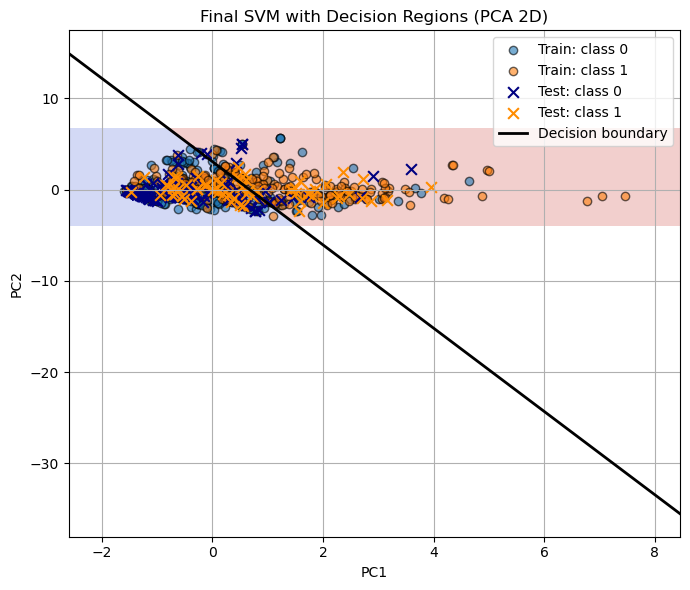

In [ ]:
# visualization of final SVM in 2D PCA space
def plot_final_svm_with_regions(svm_model, X_tr, y_tr, X_te, y_te):
    plt.figure(figsize=(7,6))

    # Build a mesh grid
    x_min = min(X_tr[:,0].min(), X_te[:,0].min()) - 1
    x_max = max(X_tr[:,0].max(), X_te[:,0].max()) + 1
    y_min = min(X_tr[:,1].min(), X_te[:,1].min()) - 1
    y_max = max(X_tr[:,1].max(), X_te[:,1].max()) + 1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 400),
        np.linspace(y_min, y_max, 400)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = svm_model.predict(grid).reshape(xx.shape)

    # Plot decision regions
    plt.contourf(xx, yy, Z, alpha=0.25, cmap=plt.cm.coolwarm)

    # Plot train and test with TRUE labels
    plt.scatter(X_tr[y_tr==0,0], X_tr[y_tr==0,1],
                c="tab:blue", edgecolor="k", alpha=0.6, label="Train: class 0")
    plt.scatter(X_tr[y_tr==1,0], X_tr[y_tr==1,1],
                c="tab:orange", edgecolor="k", alpha=0.6, label="Train: class 1")

    plt.scatter(X_te[y_te==0,0], X_te[y_te==0,1],
                c="navy", marker="x", s=60, label="Test: class 0")
    plt.scatter(X_te[y_te==1,0], X_te[y_te==1,1],
                c="darkorange", marker="x", s=60, label="Test: class 1")

    # Decision line
    w = svm_model.W
    b = svm_model.b
    if w[1] != 0:
        xs = np.linspace(x_min, x_max, 400)
        ys = -(w[0]*xs + b) / w[1]
        plt.plot(xs, ys, "k-", linewidth=2, label="Decision boundary")

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Final SVM with Decision Regions (PCA 2D)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call this instead of previous plot_final_svm
plot_final_svm_with_regions(svm_2d, X_train_2d, y_train, X_test_2d, y_test)